# Project 3: Web APIs and NLP

## Introduction

In this notebook, we will be covering the following:

1. [Modelling](#Modelling)
2. [Model Evaluation](#Model_Evaluation)
3. [Findings](#Findings)
4. [Conclusion and Recommendation](#Conclusion_and_Recommendation)

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

import time

#pd.set_option('display.max_rows', None)

In [2]:
# Excerpt from https://scikit-learn.org/stable/modules/feature_extraction.html

# Create a class for lemmatizer for use in hyperparameter tuning
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [3]:
# Importing dataframes

df_comb = pd.read_csv('../data/data_comb.csv')

In [4]:
df_comb.head()

,title,selftext,subreddit,title lemmatized,selftext lemmatized
0,edge regression with edge features in graph ne...,hey guys working on gnn to do edge regression ...,1,edge regression with edge feature in graph neu...,hey guy working on gnn to do edge regression u...
1,aspiring to be data analyst,can someone suggest me how should study data s...,1,aspiring to be data analyst,can someone suggest me how should study data s...
2,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...,1,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...
3,ds bi graduate certificates vs masters of ds c...,as title says know most people in the ds field...,1,d bi graduate certificate v master of d c degree,a title say know most people in the d field lo...
4,target salary for fresh phd grad in stats,hi all graduating from my phd in few months an...,1,target salary for fresh phd grad in stats,hi all graduating from my phd in few month and...


In [5]:
df_comb

,title,selftext,subreddit,title lemmatized,selftext lemmatized
0,edge regression with edge features in graph ne...,hey guys working on gnn to do edge regression ...,1,edge regression with edge feature in graph neu...,hey guy working on gnn to do edge regression u...
1,aspiring to be data analyst,can someone suggest me how should study data s...,1,aspiring to be data analyst,can someone suggest me how should study data s...
2,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...,1,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...
3,ds bi graduate certificates vs masters of ds c...,as title says know most people in the ds field...,1,d bi graduate certificate v master of d c degree,a title say know most people in the d field lo...
4,target salary for fresh phd grad in stats,hi all graduating from my phd in few months an...,1,target salary for fresh phd grad in stats,hi all graduating from my phd in few month and...
...,...,...,...,...,...
1896,made pancakedb new type of columnar db that us...,made pancakedb new type of columnar db that us...,0,made pancakedb new type of columnar db that us...,made pancakedb new type of columnar db that us...
1897,how to replace all values with one integer and...,basically binning or other as thanks,0,how to replace all value with one integer and ...,basically binning or other a thanks
1898,how to switch from etl testing role to de role,have years of work experience in etl testing a...,0,how to switch from etl testing role to de role,have year of work experience in etl testing an...
1899,has anyone done an aws live classroom training...,specifically asking for the data warehousing o...,0,ha anyone done an aws live classroom training ...,specifically asking for the data warehousing o...


## Modelling

CountVectorizer requires the the data to be a vector. Hence, we will be merging the 'title lemmatized' and 'selftext lemmatized' to form a new column that we will use for modelling. We will not be using the non-lemmatized data as the words are not in 'lemma' form and it will significantly increase time needed for model to run.

In [6]:
# Create title_selftext column using 'selftext' and 'title' columns

df_comb['lemma_comb'] = ''

for index, val in enumerate(df_comb['selftext lemmatized']):
    
    if val == df_comb['title lemmatized'][index]:
        df_comb['lemma_comb'][index] = val
    
    else:
        df_comb['lemma_comb'][index] = df_comb['title lemmatized'][index] + ' ' + str(val)
        
df_comb

,title,selftext,subreddit,title lemmatized,selftext lemmatized,lemma_comb
0,edge regression with edge features in graph ne...,hey guys working on gnn to do edge regression ...,1,edge regression with edge feature in graph neu...,hey guy working on gnn to do edge regression u...,edge regression with edge feature in graph neu...
1,aspiring to be data analyst,can someone suggest me how should study data s...,1,aspiring to be data analyst,can someone suggest me how should study data s...,aspiring to be data analyst can someone sugges...
2,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...,1,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...,how to build your own chatbot in python using ...
3,ds bi graduate certificates vs masters of ds c...,as title says know most people in the ds field...,1,d bi graduate certificate v master of d c degree,a title say know most people in the d field lo...,d bi graduate certificate v master of d c degr...
4,target salary for fresh phd grad in stats,hi all graduating from my phd in few months an...,1,target salary for fresh phd grad in stats,hi all graduating from my phd in few month and...,target salary for fresh phd grad in stats hi a...
...,...,...,...,...,...,...
1896,made pancakedb new type of columnar db that us...,made pancakedb new type of columnar db that us...,0,made pancakedb new type of columnar db that us...,made pancakedb new type of columnar db that us...,made pancakedb new type of columnar db that us...
1897,how to replace all values with one integer and...,basically binning or other as thanks,0,how to replace all value with one integer and ...,basically binning or other a thanks,how to replace all value with one integer and ...
1898,how to switch from etl testing role to de role,have years of work experience in etl testing a...,0,how to switch from etl testing role to de role,have year of work experience in etl testing an...,how to switch from etl testing role to de role...
1899,has anyone done an aws live classroom training...,specifically asking for the data warehousing o...,0,ha anyone done an aws live classroom training ...,specifically asking for the data warehousing o...,ha anyone done an aws live classroom training ...


### Baseline Accuracy

In [7]:
# Understanding the baseline accuarcy (1 for 'datascience' and 0 for 'dataengineering')
# Serves as a baseline for our model to beat

df_comb['subreddit'].value_counts(normalize = True)

0    0.504471
1    0.495529
Name: subreddit, dtype: float64

### Train-test-splitting

In [8]:
# Splitting X and y 

X = df_comb['lemma_comb']
y = df_comb['subreddit']

In [9]:
# Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

## <a name='Model_Evaluation'></a>Model Evaluation

For our model selection and evaluation, we will be testing three models, the **Multinomial Naive Bayes model**, **Logistic Regression model** and **Random Forest model** and vectorizing with **CountVectorizer** and **TfidfVectorizer**.

### Stopwords

We will be removing the stop words that we identified during EDA together with an in-built function 'english'. This is to ensure that the stopwords are not taken into account during modelling.

In [10]:
# Importing additional words into default 'english' stopwords

stop_words = set(stopwords.words('english'))
to_extend = ['science','datascience','scientist','engineering','engineer','dataengineering','www','com','amp',
             'x200b','data','like','know','job','good','https','youtube','png','best','hi','vs','thanks'] 
print('Stopwords before:', len(stop_words))
stop_words = stop_words.union(to_extend)
stop_words = list(stop_words)
print('Stopwords after:', len(stop_words))

Stopwords before: 179
Stopwords after: 201


### Setting Pipelines and GridSearchCV Testing (Multinomial Naive Bayes)

In [11]:
# Creating pipeline with cvec transformer and multinomial naive-bayes estimator

p1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [12]:
print(X_train.shape)
print(y_train.shape)

(1425,)
(1425,)


In [13]:
# GridSearch for pipeline 1

# Setting parameters for GridSearch 1 (CountVectorizer)
p1_params = {
    'cvec__max_features': [1000, 1_500, 2_000],
    'cvec__stop_words':[stop_words],
    'cvec__min_df':[2,3],
    'cvec__ngram_range': [(1,2),(2,2)],
    'nb__alpha':[0.75, 1.0]
}

In [14]:
%%time

# Fitting gs1 into X_train, y_train

gs1 = GridSearchCV(p1, p1_params, cv = 5, scoring = 'accuracy', n_jobs = -1)

gs1.fit(X_train, y_train)

print('Best score:',gs1.best_score_)

print('Best params:',gs1.best_params_)

print('Train score:',gs1.score(X_train, y_train))

print('Test score:',gs1.score(X_test, y_test))

Best score: 0.7950877192982457
Best params: {'cvec__max_features': 1500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 'over', 'no', 'only', 'be', 't', 'youtube', 'we', 'y', 'whic

In [15]:
# Function to plot classification scoring matrices

def plot_classification(gridscv):
    pred = gridscv.predict(X_test)
    
    cm = confusion_matrix(y_test,pred)
    
    plot_confusion_matrix(gridscv, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['dataengineering', 'datascience'])

    print(classification_report(y_test,pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    sens = tp / (tp + fn)

    print(f'Sensitivity: {round(sens, 4)}')

    spec = tn / (tn + fp)

    print(f'Specificity: {round(spec, 4)}')

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       240
           1       0.74      0.80      0.77       236

    accuracy                           0.76       476
   macro avg       0.76      0.76      0.76       476
weighted avg       0.76      0.76      0.76       476

Sensitivity: 0.8008
Specificity: 0.7208


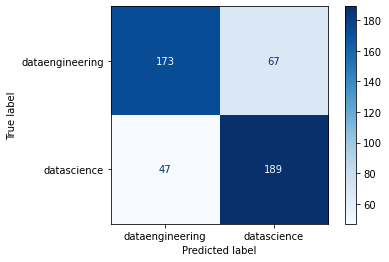

In [16]:
plot_classification(gs1)

In [17]:
# Creating pipeline with TVIDF transformer and multinomial naive-bayes estimator

p2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [18]:
# Setting hyperparameters for GridSearch2 (Tfidf)

p2_params = {
    'tvec__max_features': [3000, 4000, 5000],
    'tvec__stop_words':[stop_words],
    'tvec__min_df':[2,3],
    'tvec__ngram_range':[(1,2),(2,2)],
    'nb__alpha':[0.5, 1.0]
}

In [19]:
%%time

# Fitting gs2 into X_train, y_train

gs2 = GridSearchCV(p2, p2_params, cv = 5, scoring = 'accuracy', n_jobs = -1)

gs2.fit(X_train, y_train)

print('Best score:',gs2.best_score_)

print('Best params:',gs2.best_params_)

print('Train score:',gs2.score(X_train, y_train))

print('Test score:',gs2.score(X_test, y_test))

Best score: 0.8014035087719298
Best params: {'nb__alpha': 1.0, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 'over', 'no', 'only', 'be', 't', 'youtube'

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       240
           1       0.78      0.82      0.80       236

    accuracy                           0.80       476
   macro avg       0.80      0.80      0.80       476
weighted avg       0.80      0.80      0.80       476

Sensitivity: 0.8178
Specificity: 0.7792


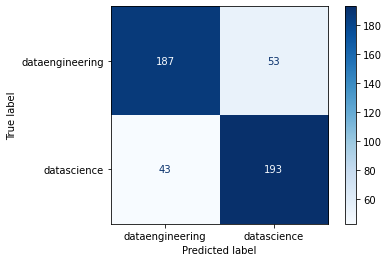

In [20]:
plot_classification(gs2)

Accuracy for multinomial naive bayes was higher when paired with TfidfVectorizer but model is highly overfit as compared to multinomial naive bayes paired with CountVectorizer. Sensitivity is higher for both models as there is higher number of false positives than false negatives. 

### Setting Pipelines and GridSearchCV Testing (Logistic Regression)

In [21]:
# Creating pipeline with CountVectorizer transformer and Logistic Regression estimator

p3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [22]:
# Setting hyperparameters for GridSearch3 (CountVectorizer)

p3_params = {
    'cvec__max_features': [3500, 4000, 4500],
    'cvec__stop_words':[stop_words],
    'cvec__min_df':[2,3],
    'cvec__ngram_range':[(1,2),(2,2)],
    'lr__C':[0.50,1],
    'lr__penalty':['l1','l2'],
    'lr__solver':['liblinear']
}

In [23]:
%%time

# Fitting gs3 into X_train, y_train

gs3 = GridSearchCV(p3, p3_params, cv = 5, scoring = 'accuracy', n_jobs = -1)

gs3.fit(X_train, y_train)

print('Best score:',gs3.best_score_)

print('Best params:',gs3.best_params_)

print('Train score:',gs3.score(X_train, y_train))

print('Test score:',gs3.score(X_test, y_test))

Best score: 0.8014035087719298
Best params: {'cvec__max_features': 4500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 'over', 'no', 'only', 'be', 't', 'youtube', 'we', 'y', 'whic

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       240
           1       0.73      0.80      0.76       236

    accuracy                           0.76       476
   macro avg       0.76      0.76      0.76       476
weighted avg       0.76      0.76      0.76       476

Sensitivity: 0.7966
Specificity: 0.7167


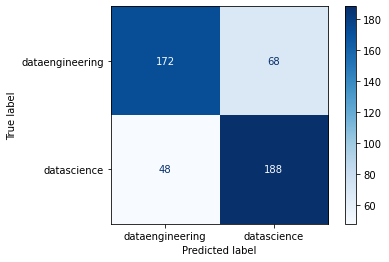

In [24]:
plot_classification(gs3)

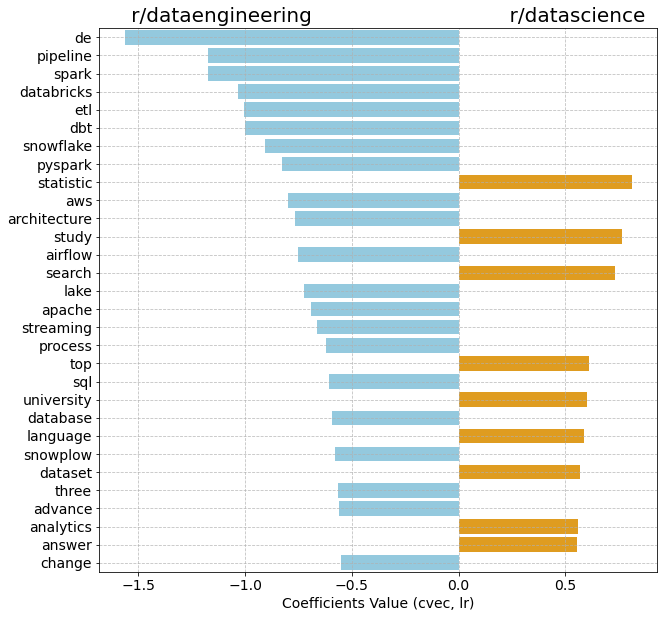

In [25]:
# Plotting the top 30 words in both subreddits for LogisticRegression model 

lr_coef2 = gs3.best_estimator_['lr'].coef_[0]
lr_names2 = gs3.best_estimator_['cvec'].get_feature_names()
lr_coef_df2 = pd.DataFrame(lr_coef2, index = lr_names2, columns = ['coef'])
lr_coef_df2['abs_coef'] = abs(lr_coef_df2['coef'])
lr_coef_plot2 = lr_coef_df2.sort_values(ascending = False, by = 'abs_coef').head(30)
lr_coef_plot2

# define a list of colour according to positive or negative values
color_lst = ['skyblue' if float(x) < 0  else 'orange' for x in lr_coef_plot2['coef']]

# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = lr_coef_plot2['coef'],
            y = lr_coef_plot2.index,
            palette = color_lst)
plt.title('   r/dataengineering                               r/datascience', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value (cvec, lr)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

In [26]:
# Creating pipeline with TFIDFVectorizer transformer and Logistic Regression estimator

p4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [27]:
p4_params = {
    'tvec__max_features': [3500, 4000, 4500,],
    'tvec__stop_words':[stop_words],
    'tvec__min_df':[2,3],
    'tvec__ngram_range':[(1,2),(2,2)],
    'lr__C': [0.5, 1],
    'lr__penalty':['l1','l2'],
    'lr__solver':['liblinear']
}

In [28]:
%%time

# Fitting gs4 into X_train, y_train

gs4 = GridSearchCV(p4, p4_params, cv = 5, scoring = 'accuracy', n_jobs = -1)

gs4.fit(X_train, y_train)

print('Best score:',gs4.best_score_)

print('Best params:',gs4.best_params_)

print('Train score:',gs4.score(X_train, y_train))

print('Test score:',gs4.score(X_test, y_test))

Best score: 0.8175438596491228
Best params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       240
           1       0.80      0.82      0.81       236

    accuracy                           0.81       476
   macro avg       0.81      0.81      0.81       476
weighted avg       0.81      0.81      0.81       476

Sensitivity: 0.822
Specificity: 0.7917


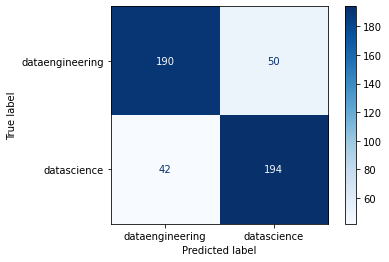

In [29]:
plot_classification(gs4)

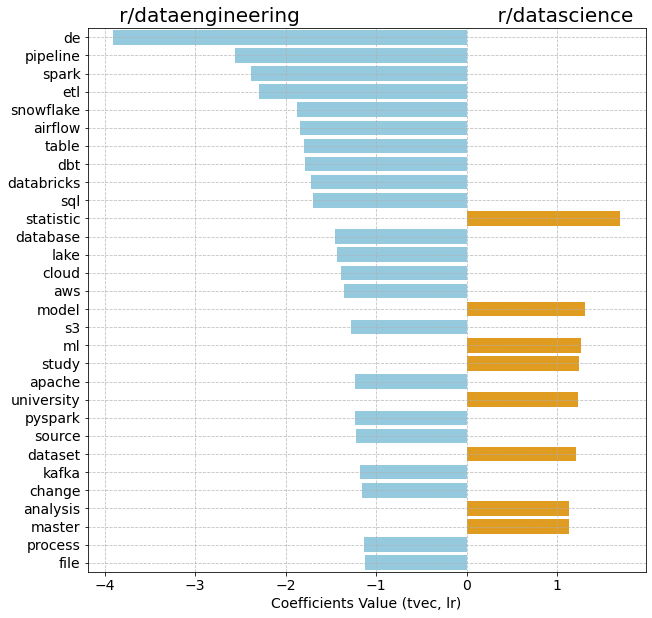

In [32]:
# Plotting the top 30 words in both subreddits for LogisticRegression model 

lr_coef1 = gs4.best_estimator_['lr'].coef_[0]
lr_names1 = gs4.best_estimator_['tvec'].get_feature_names()
lr_coef_df1 = pd.DataFrame(lr_coef1, index = lr_names1, columns = ['coef'])
lr_coef_df1['abs_coef'] = abs(lr_coef_df1['coef'])
lr_coef_plot1 = lr_coef_df1.sort_values(ascending = False, by = 'abs_coef').head(30)
lr_coef_plot1

# define a list of colour according to positive or negative values
color_lst = ['skyblue' if float(x) < 0  else 'orange' for x in lr_coef_plot1['coef']]

# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = lr_coef_plot1['coef'],
            y = lr_coef_plot1.index,
            palette = color_lst)
plt.title('   r/dataengineering                               r/datascience', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value (tvec, lr)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

For both CountVectorizer and TfidfVectorizer, we see that the words that give the most predictive power to both subreddits are almost identical. However, the TfidfVectorizer has a better score due to the it taking into account the importance of the word on top of the frequency of the word.

### Setting Pipelines and GridSearchCV Testing (Random Forest)

In [33]:
# Creating pipeline with CountVectorizer transformer and Random Forest estimator

p5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [34]:
p5_params = {
    'cvec__max_features': [1500, 2000, 2500],
    'cvec__stop_words':[stop_words],
    'cvec__min_df':[2,3],
    'cvec__ngram_range':[(1,2),(2,2)],
    'rf__n_estimators':[150, 200, 250],
    'rf__max_depth':[None, 1, 2]
}

In [35]:
%%time

# Fitting gs5 into X_train, y_train

gs5 = GridSearchCV(p5, p5_params, cv = 5, scoring = 'accuracy', n_jobs = -1)

gs5.fit(X_train, y_train)

print('Best score:',gs5.best_score_)

print('Best params:',gs5.best_params_)

print('Train score:',gs5.score(X_train, y_train))

print('Test score:',gs5.score(X_test, y_test))

Best score: 0.807719298245614
Best params: {'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 'over', 'no', 'only', 'be', 't', 'youtube', 'we', 'y', 'which

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       240
           1       0.76      0.79      0.78       236

    accuracy                           0.77       476
   macro avg       0.77      0.77      0.77       476
weighted avg       0.77      0.77      0.77       476

Sensitivity: 0.7924
Specificity: 0.7542


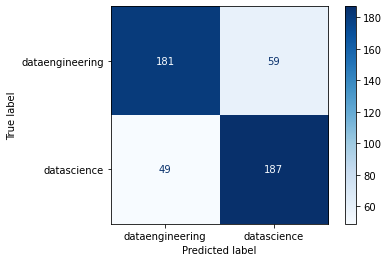

In [36]:
plot_classification(gs5)

In [37]:
gs_tfrf_coef1 = gs5.best_estimator_['rf'].feature_importances_
gs_tfrf_coef_names1 = gs5.best_estimator_['cvec'].get_feature_names()
gs_tfrf_df1 = pd.DataFrame(gs_tfrf_coef1, index = gs_tfrf_coef_names1, columns = ['coef'])
gs_tfrf_df1.sort_values(ascending = False, by = ['coef']).head(30)

,coef
de,0.029143
pipeline,0.017752
etl,0.016133
spark,0.015687
table,0.011617
airflow,0.011389
dbt,0.010034
snowflake,0.009901
statistic,0.009325
databricks,0.008106


In [38]:
# Creating pipeline with TfidfVectorizer transformer and Random Forest estimator

p6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [39]:
p6_params = {
    'tvec__max_features': [1500, 2000, 2500 ],
    'tvec__stop_words':[stop_words],
    'tvec__min_df':[2,3],
    'tvec__ngram_range':[(1,2),(2,2)],
    'rf__n_estimators':[125, 150, 175],
    'rf__max_depth':[None, 1, 2]
}

In [40]:
%%time

# Fitting gs6 into X_train, y_train

gs6 = GridSearchCV(p6, p6_params, cv = 5, scoring = 'accuracy',n_jobs = -1)

gs6.fit(X_train, y_train)

print('Best score:',gs6.best_score_)

print('Best params:',gs6.best_params_)

print('Train score:',gs6.score(X_train, y_train))

print('Test score:',gs6.score(X_test, y_test))

Best score: 0.7950877192982457
Best params: {'rf__max_depth': None, 'rf__n_estimators': 150, 'tvec__max_features': 1500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ["you've", 'all', 'own', 'ma', "isn't", 'can', "mightn't", 'have', 'won', 'job', 'our', 'below', 'when', 'will', 'now', 'hadn', 'couldn', 'does', 'doing', 'on', 'very', 'engineer', 'he', 'while', 'it', "aren't", 'each', 'other', 'll', 'who', 'o', "should've", 'above', 'aren', 'did', 'his', 'how', 'until', 'and', 'dataengineering', 'its', 'am', 'then', "mustn't", "hadn't", 'this', 'him', 'm', "she's", 'wasn', 'off', 'a', 'after', 'has', 'hers', 'was', "you're", 'www', "it's", 've', 'they', 'before', 'were', 'why', 'theirs', 'shan', 're', 'ourselves', 'against', 'isn', 'mustn', 'like', 'png', 'my', 'them', 'doesn', 'as', 'didn', 'same', 'than', 'hasn', 'herself', 'themselves', "doesn't", 'science', 'through', 'so', 'your', 'during', 'to', 'most', 'at', 'into', 'her', 'more', 'some', 'the', 'over', 'no'

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       240
           1       0.74      0.86      0.80       236

    accuracy                           0.78       476
   macro avg       0.79      0.78      0.78       476
weighted avg       0.79      0.78      0.78       476

Sensitivity: 0.8559
Specificity: 0.7083


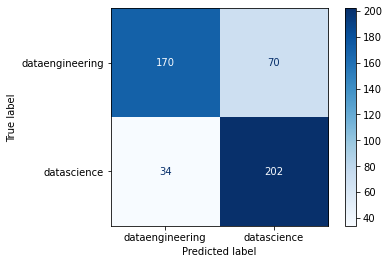

In [41]:
plot_classification(gs6)

In [42]:
gs_tfrf_coef = gs6.best_estimator_['rf'].feature_importances_
gs_tfrf_coef_names = gs6.best_estimator_['tvec'].get_feature_names()
gs_tfrf_df = pd.DataFrame(gs_tfrf_coef, index = gs_tfrf_coef_names, columns = ['coef'])
gs_tfrf_df.sort_values(ascending = False, by = ['coef']).head(30)

,coef
de,0.029988
pipeline,0.019900
spark,0.018058
etl,0.014371
airflow,0.013523
statistic,0.011306
table,0.010611
dbt,0.010169
snowflake,0.009789
databricks,0.009129


The words with highest feature importance seem to refer to terms in data engineering (apart from 'statistic'). This is further corroborated with the sensitivity higher than specificity for both random forest models. It seems like the model is able to predict 'data engineering' subreddits with better accuracy than 'data science.'

### Model Selection

As both false positives and false negatives are equally detrimental in prediction, we will be choosing the model with the highest accuracy in prediction, which is the **Logistic Regression with TfidfVectorization** and plotting further matrices with this model on the test data.

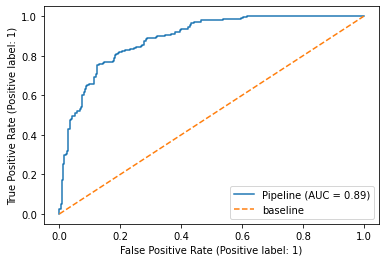

In [43]:
# Instatiating new model with best params and plot_roc_curve(lr, X_test, y_test)
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(max_features = 3500, stop_words = stop_words, ngram_range = [1,2], min_df = 2)),
    ('lr',LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear'))
    ])

# Fit model
pipe.fit(X_train, y_train)
     
# Predict y_test results and plot ROC AUC curve

plot_roc_curve(pipe, X_test, y_test)   
     
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()

In [44]:
roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])

0.8900070621468927

A score of 0.89 for our ROC curve means that there is not much overlap between the positives and negatives. A score of 1 signifies a perfect model.

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       240
           1       0.80      0.82      0.81       236

    accuracy                           0.81       476
   macro avg       0.81      0.81      0.81       476
weighted avg       0.81      0.81      0.81       476

Sensitivity: 0.822
Specificity: 0.7917


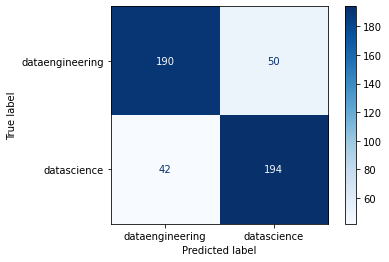

In [45]:
# Plot chosen model metrics with best params

plot_classification(pipe)

## Findings

| |Train Accuracy|Test Accuracy|
|---|---|---|
|**Multinomial Naive Bayes (CountVectorization)**|0.847|0.760|
|**Multinomial Naive Bayes (TfidfVectorization)**|0.905|0.798|
|**Logistic Regression (CountVectorization)**|0.982|0.756|
|**Logistic Regression (TfidfVectorization)**|0.943|0.806|
|**Random Forest Classifier (CountVectorizer)**|0.994|0.773|
|**Random Forest Classifier (TfidfVectorizer)**|0.994|0.781|

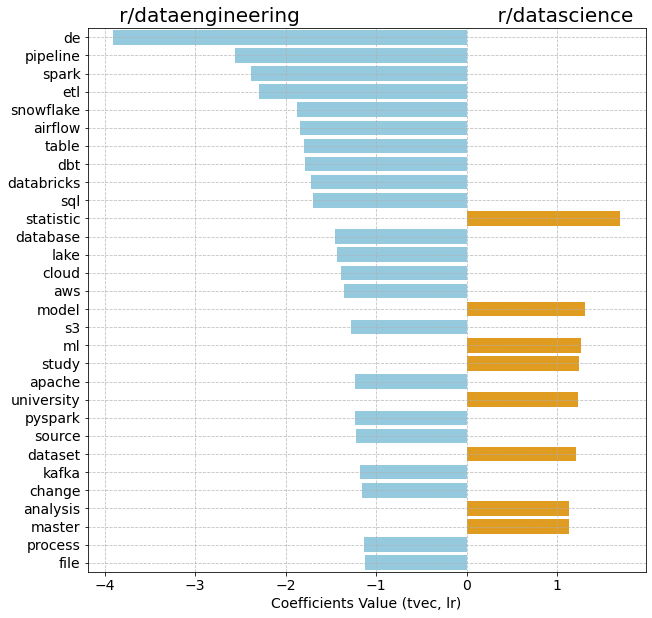

In [46]:
# Plotting the top 30 words in both subreddits for LogisticRegression model 

lr_coef1 = gs4.best_estimator_['lr'].coef_[0]
lr_names1 = gs4.best_estimator_['tvec'].get_feature_names()
lr_coef_df1 = pd.DataFrame(lr_coef1, index = lr_names1, columns = ['coef'])
lr_coef_df1['abs_coef'] = abs(lr_coef_df1['coef'])
lr_coef_plot1 = lr_coef_df1.sort_values(ascending = False, by = 'abs_coef').head(30)
lr_coef_plot1

# define a list of colour according to positive or negative values
color_lst = ['skyblue' if float(x) < 0  else 'orange' for x in lr_coef_plot1['coef']]

# plot barplot
plt.figure(figsize = (10,10))
sns.barplot(x = lr_coef_plot1['coef'],
            y = lr_coef_plot1.index,
            palette = color_lst)
plt.title('   r/dataengineering                               r/datascience', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Coefficients Value (tvec, lr)', fontsize = 14)
plt.grid(linestyle = '--', alpha = 0.8);

It is interesting to note that after removing similar keywords, stopwords and hyperparameter tuning, the models still turns out to be rather overfit, with some models being overfit as much as 22%. The number of false positives are also higher than the false negatives across all models tested. Comparing vectorizers, **TfidfVectorizer** appears to do better in terms of accuracy than CountVectorizer.

The results serves to show that data science and data engineering are ultimately very closely related. As we are prioritising on accuracy, the model we have chosen is the **LogisticRegression(TfidfVectorizer)** model (80% accuracy). It is worthy to note that while this model has the highest accuracy score, the **Multinomial Naive Bayes(CountVectorizer)** model has the least overfit compared to the other models tested.

In [47]:
# Plotting top30 words for each subreddit

# Datascience
coef4 = gs4.best_estimator_.named_steps['lr'].coef_
features4 = gs4.best_estimator_.named_steps['tvec'].get_feature_names()
coef_df = pd.DataFrame({'top words': features4,'coef': coef4[0]},index = features4)
coef_df['log_odds'] = coef_df['coef'].map(lambda x: math.exp(x))
coef_df = coef_df.sort_values('log_odds', ascending = False)
coef_df.head(10)

# Dataengineering
coef_df1 = pd.DataFrame({'top words': features4,'coef': coef4[0]},index = features4)
coef_df['log_odds'] = coef_df['coef'].map(lambda x: math.exp(x))
coef_df = coef_df.sort_values('log_odds', ascending = False)
coef_df.head(10)

,top words,coef,log_odds
statistic,statistic,1.697906,5.462497
model,model,1.313405,3.718816
ml,ml,1.261807,3.531798
study,study,1.241853,3.462023
university,university,1.232917,3.431224
dataset,dataset,1.205594,3.338743
analysis,analysis,1.136973,3.117317
master,master,1.131142,3.099195
degree,degree,1.097154,2.995629
research,research,1.094171,2.986705


In [48]:
# Setting labels for plotting top 20 words

weights = coef_df['coef'].sort_values(ascending = False).head(20)
weights_reverse = coef_df['coef'].sort_values(ascending = True).head(20)
labels = weights.index
labels_reverse = weights_reverse.index

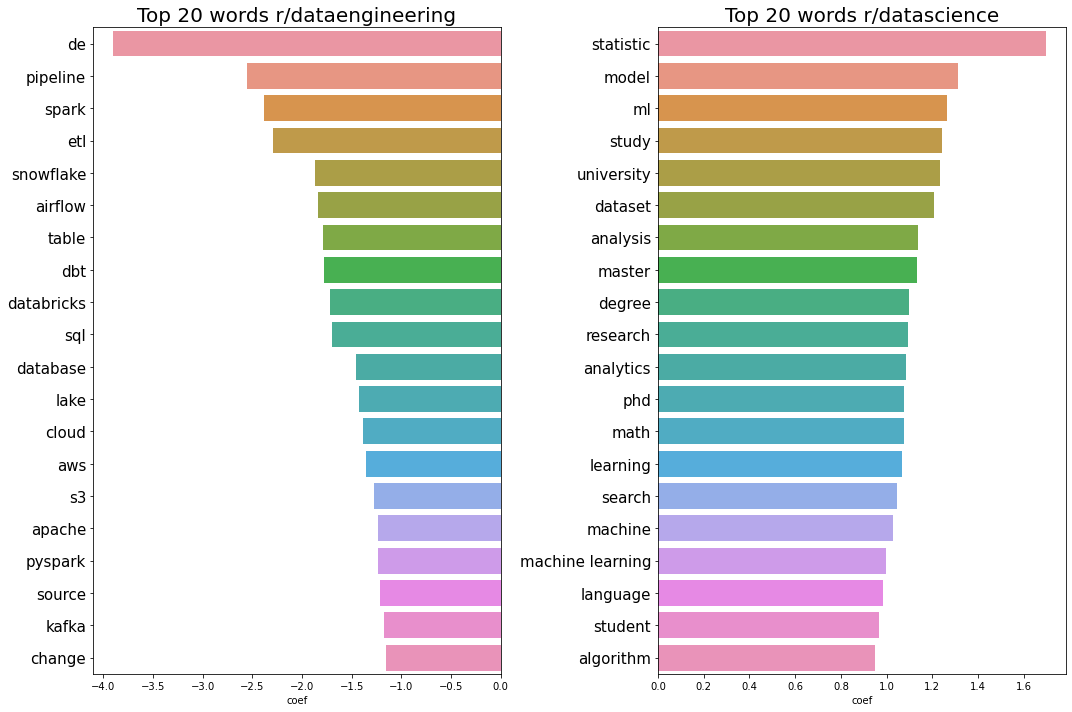

In [49]:
# Plotting top 20 words for each subreddit

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 10))
sns.set_color_codes("muted")

# Barplot for r/dataengineering
sns.barplot(ax = ax[0],x = weights_reverse, y = labels_reverse,
            data = coef_df, 
            orient = "h")
ax[0].set_title('Top 20 words r/dataengineering', fontsize = 20)
ax[0].set_yticklabels(labels_reverse, Fontsize = 15)

# Barplot for r/datascience
sns.barplot(ax = ax[1], x = weights, y = labels, 
            data = coef_df,
            orient = "h")
ax[1].set_title('Top 20 words r/datascience', fontsize = 20)
ax[1].set_yticklabels(labels, Fontsize = 15)
plt.tight_layout()

The top words in data engineering reddits tend to revolve around data engineering tools such as snowflake, spark, airflow. The word that gave the most predictive power for dataengineering was 'de', which stands for 'data engineering'. Words from the data science reddits are more analytical and academic in nature. The word which lends the most predictive power was 'statistic', a study that data scientists excel in.

## Conclusion and Recommendation

With an accuracy score of 80%, the **Logistic Regression model with TfidfVectorizer** was the best performer among the models tested, albeit not by a huge margin. Among the tested models, TfidfVectorizers tend to score better than CountVectorizer models and random forest models have a high degree of overfit.

Even though the subreddit topics are closely related in nature, we can see through the top words in each posts that they do have their differences. Words in dataengineering reddit posts tend to steer towards technical terms and data engineering tools such as 'spark','snowflake', 'apache' and 'airflow'. These are tools which data engineers commonly use. 

On the other hand, top words in datascience reddit posts are more academic and analytical in nature. Words such as 'statistics', 'model', 'ml', 'dataset' are very relevant to what data scientists do on a daily basis. It is also interesting to note that there are some words such as 'university', 'degree', 'master', 'study', 'phd', which suggests that the entry barrier into this field is high and it is very academic in nature. This is to be expected with data science being a highly sought after industry as of recent years and data scientist roles being termed 'The Sexiest Job of the 21st Century'. 

To improve model accuracy, a bigger dataset with more vocabulary could be obtained. The industry is changing at a very rapid pace, with new machine learning models, data engineering tools being developed every few years to futher streamline processes, make learning about data easier and generally helps people be familiar with the concept of living with data. We could also look to increase the range of models to test on, such as K-Nearest-Neighbor, Support Vector Machine or explore using other classifier methods such as word similarities with Word2Vec or vector distances with GloVe.